In [1]:
from simulation.simulator import Simulator

In [2]:
def diffeq_lorenz_system(t, z, args):
    """
    Coupled differential equations representing the Lorenz system.
    """
    sigma, rho, beta = args
    x1, x2, x3 = z
    dx1dt = sigma * (x2 - x1)
    dx2dt = x1 * (rho - x3) - x2
    dx3dt = x1 * x2 - beta * x3
    return [dx1dt, dx2dt, dx3dt]

In [3]:
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0

ics = []
for i in range(0, 100):
    x1_0 = 5.0 + 0.001 * i
    x2_0 = 1.0
    x3_0 = 1.0
    ics.append([x1_0, x2_0, x3_0])

In [4]:
scipy_sim = Simulator("scipy")

In [5]:
scipy_sim.cpu_sequential_solve_ics(
    ics, diffeq_lorenz_system, [sigma, rho, beta], 0.0, 100.0, 0.01
)

In [6]:
scipy_sim.cpu_parallel_solve_ics(
    ics=ics, num_processes=10, diffeq_func=diffeq_lorenz_system, args=[sigma, rho, beta], ti=0.0, tf=100.0, dt=0.01, 
)

Benchmarked time = 0.8308520317077637
Function benchmarked was: <function Simulator.cpu_parallel_solve_ics at 0x78046257f520>


cpu_serial_solve_ics(ics, scipy_sim, diffeq_lorenz_system, [])

<module 'matplotlib.pyplot' from '/home/fichte/Public_Projects/GitHub/diffeq-bench/venv-diffeqs/lib/python3.10/site-packages/matplotlib/pyplot.py'>

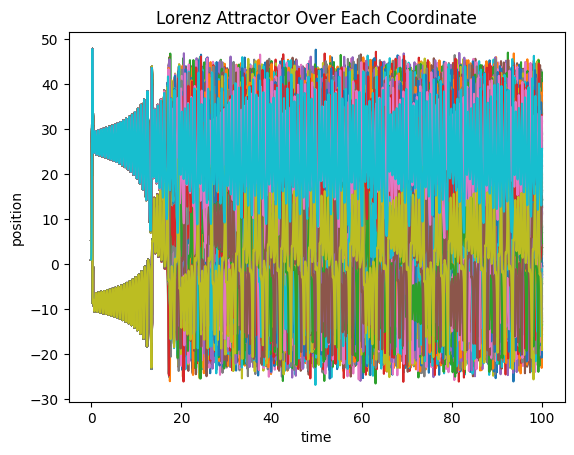

In [7]:
scipy_sim.plot_numeric_sol_ivp(
    label_x="time", label_y="position", title="Lorenz Attractor Over Each Coordinate"
)